DATA_PREP.py

In [1]:
import numpy as np
from math import ceil
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, functional

/users/PES0841/yizicheng/.conda/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class THICKNESS(Dataset):
    def __init__(self, input_nm = 'x', output_nm = 'y', mode = 'train', transform=None):
        if mode == 'train':
            root_input = input_nm + '_train.npy'
            root_output = output_nm + '_train.npy'
        elif mode == 'val':
            root_input = input_nm + '_val.npy'
            root_output = output_nm + '_val.npy'
        else:
            root_input = input_nm + '_test.npy'
            root_output = output_nm + '_test.npy'
            
        self.original_input = np.load(root_input)
        self.original_output = np.load(root_output)
        self.transform = transform
        
    def __len__(self):
        return len(self.original_input)
    
    def __getitem__(self, item):
        inp = self.original_input[item]
        out = self.original_output[item]
        sample = {"input": inp, "output": out}
        if self.transform:
            sample = self.transform(sample)

        return sample
    
class ToTensor:
    def __call__(self, sample):
        sample["input"] = torch.as_tensor(sample["input"], dtype=torch.float32)
        sample["output"] = torch.as_tensor(sample["output"], dtype=torch.float32)
        
        return sample
    
def get_data(batch_size):
    transforms = ToTensor()
    
    datasets, dataloaders, dataset_sizes = {}, {}, {}
    for mode in ["train", "val", "test"]:
        datasets[mode] = THICKNESS(mode = mode, transform = transforms)
        dataloaders[mode] = DataLoader(
            datasets[mode],
            batch_size=batch_size,
            shuffle= True,
#             shuffle= mode == "train",
            num_workers=0,
        )
        dataset_sizes[mode] = len(datasets[mode])

    return datasets, dataloaders, dataset_sizes



In [3]:
datasets, dataloaders, dataset_sizes = get_data(batch_size=64)

BASELINE.py

In [4]:
device = torch.device(
        "cuda:0" if torch.cuda.is_available() else "cpu"
    )

In [5]:
# from pathlib import Path

# import numpy as np
# import torch
# import torch.nn as nn
# from tqdm import tqdm

# import pyro
# import pyro.distributions as dist
# from pyro.infer import SVI, Trace_ELBO

# x = torch.ones(30,1,171,171)

# x = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(30, 30))(x)

# x = nn.MaxPool2d(kernel_size=(5, 5), stride=(5, 5))(x)

# x = nn.MaxPool2d(kernel_size=(30, 30), stride=(30, 30))(x)

# y = torch.flatten(x, 1)

# x.shape

# y.shape

In [6]:
import copy
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm


class BaselineNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(30, 30))
        self.maxpool = nn.MaxPool2d(kernel_size=(5, 5), stride=(5, 5))
        self.fc1 = nn.Linear(7840, 100)
        self.fc2 = nn.Linear(100, 4)
        
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = x.view(-1, 171, 171)
        x = x.unsqueeze(1)
        hidden = self.leakyrelu(self.conv(x))
        hidden = self.maxpool(hidden)
        
        hidden = torch.flatten(hidden, 1)
        hidden = self.leakyrelu(self.fc1(hidden))
        
        y = self.fc2(hidden)
        return y


class MSELoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, target):
        target = target.view(input.shape)
        loss = F.mse_loss(input, target, reduction="sum")
        return loss


def train(
    device,
    dataloaders,
    dataset_sizes,
    learning_rate,
    num_epochs,
    early_stop_patience,
    model_path,
):

    # Train baseline
    baseline_net = BaselineNet()
    baseline_net.to(device)
    optimizer = torch.optim.Adam(baseline_net.parameters(), lr=learning_rate)
    criterion = MSELoss()
    best_loss = np.inf
    early_stop_count = 0

    for epoch in range(num_epochs):
        for phase in ["train", "val"]:
            if phase == "train":
                baseline_net.train()
            else:
                baseline_net.eval()

            running_loss = 0.0
            num_preds = 0

            bar = tqdm(
                dataloaders[phase], desc="NN Epoch {} {}".format(epoch, phase).ljust(20)
            )
            for i, batch in enumerate(bar):
                inputs = batch["input"].to(device)
                outputs = batch["output"].to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    preds = baseline_net(inputs)
                    loss = criterion(preds, outputs) / inputs.size(0)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item()
                num_preds += 1
                if i % 10 == 0:
                    bar.set_postfix(
                        loss="{:.2f}".format(running_loss / num_preds),
                        early_stop_count=early_stop_count,
                    )

            epoch_loss = running_loss / dataset_sizes[phase]
            # deep copy the model
            if phase == "val":
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(baseline_net.state_dict())
                    early_stop_count = 0
                else:
                    early_stop_count += 1

        if early_stop_count >= early_stop_patience:
            break

    baseline_net.load_state_dict(best_model_wts)
    baseline_net.eval()

    # Save model weights
    Path(model_path).parent.mkdir(parents=True, exist_ok=True)
    torch.save(baseline_net.state_dict(), model_path)

    return baseline_net

In [7]:
baseline_net = train(
            device=device,
            dataloaders=dataloaders,
            dataset_sizes=dataset_sizes,
            learning_rate=1.0e-3,
            num_epochs=50,
            early_stop_patience=5,
            model_path="baseline_net.pth",
        )

NN Epoch 16 val     : 100%|██████████| 59/59 [00:00<00:00, 128.69it/s, early_stop_count=4, loss=0.08]


CVAE.py

In [8]:
# Copyright Contributors to the Pyro project.
# SPDX-License-Identifier: Apache-2.0
# import os

# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, TraceMeanField_ELBO


class Encoder(nn.Module):
    def __init__(self, z_dim, out_channel_1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=5, out_channels=out_channel_1, kernel_size=(30, 30))
        self.maxpool = nn.MaxPool2d(kernel_size=(5, 5), stride=(5, 5))
        
        #in_features should be y.shape[1]
        self.fc1 = nn.Linear(in_features=7840, out_features=100)
        self.fcalpha = nn.Linear(in_features=100, out_features=z_dim)
        
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()
        self.leakyrelu = nn.LeakyReLU()
        self.tanh = nn.Tanh()

    def forward(self, x, y):
        # put x and y together in the same image for simplification
        x = x.view(-1, 171, 171)
        y = y.view(-1, 4)
        y = y.unsqueeze(2)
        #y.shape: (30,4,1)
        y_0 = y[:,0,:].repeat(1,171).unsqueeze(2).repeat(1,1,171)
        y_1 = y[:,1,:].repeat(1,171).unsqueeze(2).repeat(1,1,171)
        y_2 = y[:,2,:].repeat(1,171).unsqueeze(2).repeat(1,1,171)
        y_3 = y[:,3,:].repeat(1,171).unsqueeze(2).repeat(1,1,171)
        yc = torch.stack((y_0, y_1, y_2, y_3), dim = 1)
        xc = torch.cat((x.unsqueeze(1), yc),dim = 1)
        
        # then compute the hidden units
        hidden = self.leakyrelu(self.conv(xc))
        hidden = self.maxpool(hidden)
        
        hidden = torch.flatten(hidden, 1)
        
        hidden = self.leakyrelu(self.fc1(hidden))
    
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        alpha = self.softplus(self.fcalpha(hidden))
        
#         alpha = torch.maximum(torch.tensor((0.00001)), torch.log(1+torch.exp(alpha)))
        return alpha


class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_1):
        super().__init__()
        self.fc1 = nn.Linear(z_dim, hidden_1)
        self.fc2 = nn.Linear(hidden_1, 4)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.leakyrelu = nn.LeakyReLU()

    def forward(self, z):
        y = self.leakyrelu(self.fc1(z))
        y = self.fc2(y)
        return y


class CVAE(nn.Module):
    def __init__(self, z_dim, hidden_1, pre_trained_baseline_net):
        super().__init__()
        # The CVAE is composed of multiple MLPs, such as recognition network
        # qφ(z|x, y), (conditional) prior network pθ(z|x), and generation
        # network pθ(y|x, z). Also, CVAE is built on top of the NN: not only
        # the direct input x, but also the initial guess y_hat made by the NN
        # are fed into the prior network.
        self.baseline_net = pre_trained_baseline_net
        self.prior_net = Encoder(z_dim, 10)
        self.generation_net = Decoder(z_dim, hidden_1)
        self.recognition_net = Encoder(z_dim, 10)

    def model(self, xs, ys=None):
        # register this pytorch module and all of its sub-modules with pyro
        pyro.module("generation_net", self)
        batch_size = xs.shape[0]
        with pyro.plate("data"):

            # Prior network uses the baseline predictions as initial guess.
            # This is the generative process with recurrent connection
            with torch.no_grad():
                # this ensures the training process does not change the
                # baseline network
                y_hat = self.baseline_net(xs).view(-1,4)

            # sample the handwriting style from the prior distribution, which is
            # modulated by the input xs.
            prior_alpha = self.prior_net(xs, y_hat)
            zs = pyro.sample("z", dist.Gamma(prior_alpha, 1).to_event(1))
            zs = torch.div(zs,torch.reshape(torch.sum(zs,1), (-1, 1)))

            # the output y is generated from the distribution pθ(y|x, z)
            y_out = self.generation_net(zs)

            if ys is not None:
                # In training, we will only sample in the masked image
                pyro.sample(
                    "y",
                    dist.Normal(y_out, 0.1, validate_args=False).to_event(1),
                    obs=ys,
                )
                
            else:
                # In testing, no need to sample: the output is already a
                # probability in [0, 1] range, which better represent pixel
                # values considering grayscale. If we sample, we will force
                # each pixel to be  either 0 or 1, killing the grayscale
                pyro.deterministic("y", y_out.detach())

            # return the y_out so we can visualize it later
            return y_out

    def guide(self, xs, ys=None):
        with pyro.plate("data"):
            if ys is None:
                # at inference time, ys is not provided. In that case,
                # the model uses the prior network
                y_hat = self.baseline_net(xs).view(-1,4)
                alpha = self.prior_net(xs, y_hat)
            else:
                # at training time, uses the variational distribution
                # q(z|x,y) = normal(loc(x,y),scale(x,y))
                alpha = self.recognition_net(xs, ys)

            pyro.sample("z", dist.Gamma(alpha, 1).to_event(1))


def train(
    device,
    dataloaders,
    dataset_sizes,
    learning_rate,
    num_epochs,
    early_stop_patience,
    model_path,
    pre_trained_baseline_net,
):

    # clear param store
    pyro.clear_param_store()

    cvae_net = CVAE(10, 100, pre_trained_baseline_net)
    cvae_net.to(device)
    optimizer = pyro.optim.Adam({"lr": learning_rate})
    svi = SVI(cvae_net.model, cvae_net.guide, optimizer, loss=TraceMeanField_ELBO())

    best_loss = np.inf
    early_stop_count = 0
    Path(model_path).parent.mkdir(parents=True, exist_ok=True)

    for epoch in range(num_epochs):
        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            running_loss = 0.0
            num_preds = 0

            # Iterate over data.
            bar = tqdm(
                dataloaders[phase],
                desc="CVAE Epoch {} {}".format(epoch, phase).ljust(20),
            )
            for i, batch in enumerate(bar):
                inputs = batch["input"].to(device)
                outputs = batch["output"].to(device)

                if phase == "train":
                    loss = svi.step(inputs, outputs)
                else:
                    loss = svi.evaluate_loss(inputs, outputs)

                # statistics
                running_loss += loss / inputs.size(0)
                num_preds += 1
                if i % 10 == 0:
                    bar.set_postfix(
                        loss="{:.2f}".format(running_loss / num_preds),
                        early_stop_count=early_stop_count,
                    )

            epoch_loss = running_loss / dataset_sizes[phase]
            # deep copy the model
            if phase == "val":
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(cvae_net.state_dict(), model_path)
                    early_stop_count = 0
                else:
                    early_stop_count += 1

        if early_stop_count >= early_stop_patience:
            break

    # Save model weights
    cvae_net.load_state_dict(torch.load(model_path))
    cvae_net.eval()
    return cvae_net

In [10]:
# seed = 0
# torch.manual_seed(seed)
# pyro.set_rng_seed(seed)

cvae_net = train(
            device=device,
            dataloaders=dataloaders,
            dataset_sizes=dataset_sizes,
            learning_rate=1.0e-4,
            num_epochs=500,
            early_stop_patience=20,
            model_path="gamma_Dircvae.pth",
            pre_trained_baseline_net=baseline_net,
        )

CVAE Epoch 72 val   : 100%|██████████| 59/59 [00:08<00:00,  6.58it/s, early_stop_count=19, loss=-0.61]


PREDICT.py

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from pyro.infer import Predictive, TraceMeanField_ELBO

In [ ]:
# def generate_table(
#     device,
#     pre_trained_baseline,
#     pre_trained_cvae,
#     num_particles,
#     col_name,
# ):

#     # Load sample random data
#     datasets, dataloaders, dataset_sizes = get_data(batch_size=2)

#     # Load sample data
#     criterion = MSELoss()
#     loss_fn = Trace_ELBO(num_particles=num_particles).differentiable_loss

#     baseline_cll = 0.0
#     cvae_mc_cll = 0.0
#     num_preds = 0

#     df = pd.DataFrame(index=["NN (baseline)", "CVAE (Monte Carlo)"], columns=[col_name])

#     # Iterate over data.
#     bar = tqdm(dataloaders["val"], desc="Generating predictions".ljust(20))
#     for batch in bar:
#         inputs = batch["input"].to(device)
#         outputs = batch["output"].to(device)
#         num_preds += 1

#         # Compute negative log likelihood for the baseline NN
#         with torch.no_grad():
#             preds = pre_trained_baseline(inputs)
#         baseline_cll += criterion(preds, outputs).item() / inputs.size(0)

#         # Compute the negative conditional log likelihood for the CVAE
#         cvae_mc_cll += loss_fn(
#             pre_trained_cvae.model, pre_trained_cvae.guide, inputs, outputs
#         ).detach().item() / inputs.size(0)

#     df.iloc[0, 0] = baseline_cll / num_preds
#     df.iloc[1, 0] = cvae_mc_cll / num_preds
#     return df

In [ ]:
# df = generate_table(
#             device=device,
#             pre_trained_baseline=baseline_net,
#             pre_trained_cvae=cvae_net,
#             num_particles=10,
#             col_name="CLLs",
#         )

In [ ]:
# df

In [ ]:
# datasets, dataloaders, dataset_sizes = get_data(batch_size=32)

In [12]:
num_images = dataset_sizes['test']
num_samples = 1000

In [13]:
dataloader = DataLoader(datasets["test"], batch_size=num_images, shuffle=False)

batch = next(iter(dataloader))

inputs = batch["input"].to(device)
outputs = batch["output"].to(device)

# Make predictions for baseline
with torch.no_grad():
    baseline_preds = baseline_net(inputs).view(outputs.shape)

# Make predictions for cvae
predictive = Predictive(
    cvae_net.model, guide=cvae_net.guide, num_samples=num_samples
)
cvae_preds = predictive(inputs)["y"].view(num_samples, num_images, 4)

In [14]:
y_test = outputs.cpu().detach().numpy()

In [15]:
# dir_cvae_preds = cvae_preds
# dir_cvae_preds = dir_cvae_preds.cpu().detach().numpy()
# np.save('dir_cvae_preds.npy', dir_cvae_preds)

In [16]:
baseline_preds = baseline_preds.cpu().detach().numpy()
cvae_preds = cvae_preds.cpu().detach().numpy()

In [21]:
# np.save('baseline_preds.npy', baseline_preds)
np.save('gamma_Dircvae_preds.npy', cvae_preds)

BASELINE PREDICTION

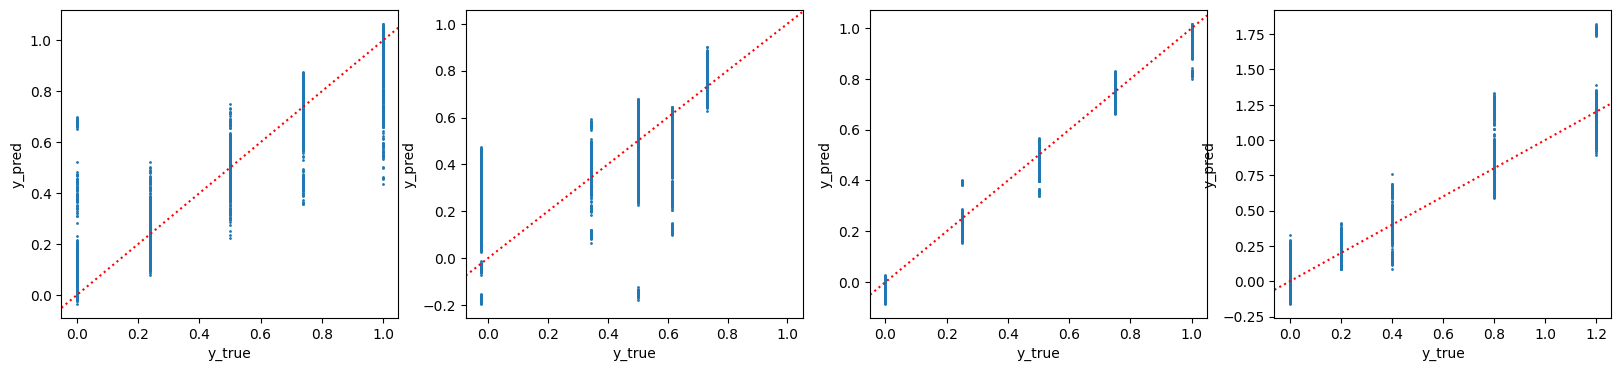

In [17]:
#plotting:baseline

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))
plt.subplots_adjust(hspace=0.5)

for i, ax in enumerate(axs.ravel()):
    ax.scatter(y_test[:,i], baseline_preds[:,i], s=1.0)
    ax.set_xlabel('y_true')
    ax.set_ylabel('y_pred')
    ax.axline([0, 0], [1, 1], linestyle='dotted', color='red')

CVAE PREDICTION WITHOUT CI

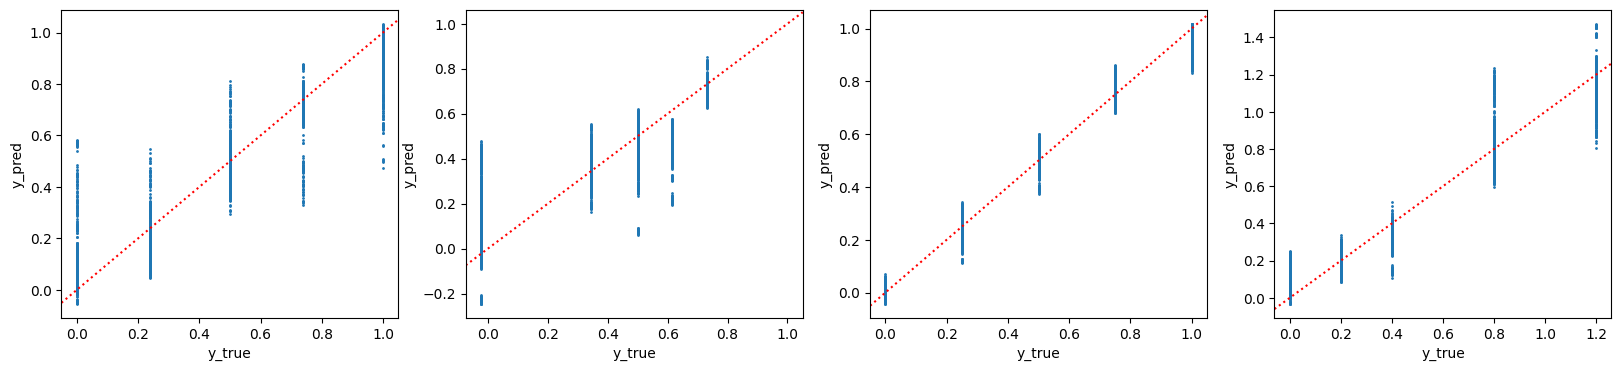

In [18]:
#plotting:cvae

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))
plt.subplots_adjust(hspace=0.5)

for i, ax in enumerate(axs.ravel()):
    mean = np.mean(cvae_preds[:,:,i], axis=0)
    
    ax.scatter(y_test[:,i], mean, s=1.0)
    ax.set_xlabel('y_true')
    ax.set_ylabel('y_pred')
    ax.axline([0, 0], [1, 1], linestyle='dotted', color='red')

CVAE PREDICTION WITH CI

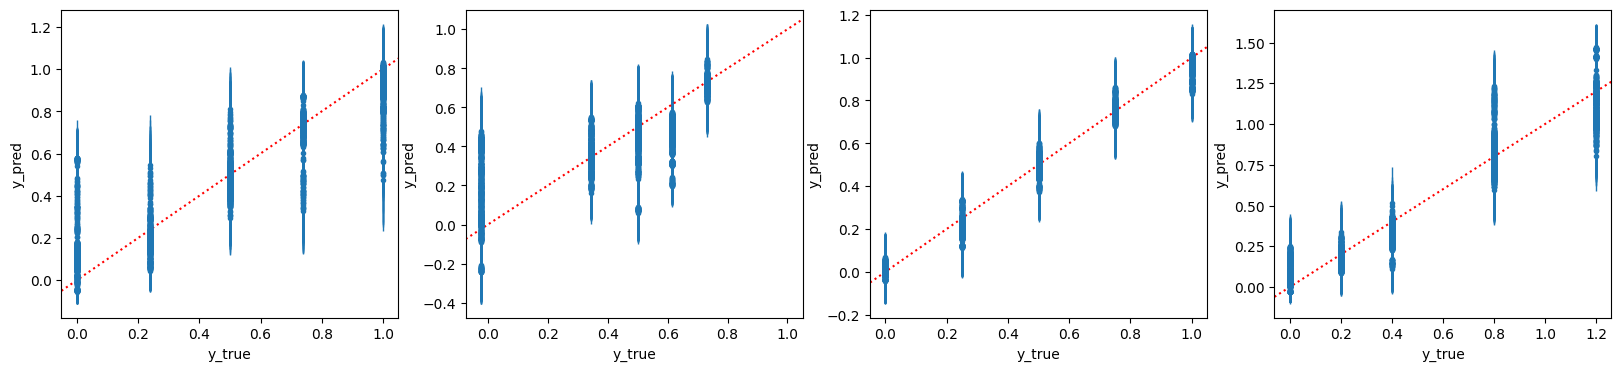

In [19]:
#plotting:cvae

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))
plt.subplots_adjust(hspace=0.5)

for i, ax in enumerate(axs.ravel()):
    mean = np.mean(cvae_preds[:,:,i], axis=0)
    std = np.std(cvae_preds[:,:,i], axis=0)
    ci = 1.96 * std
    
    ax.errorbar(y_test[:,i], mean, yerr=ci, fmt='o', markersize=3.0, linewidth=1.0)
    ax.set_xlabel('y_true')
    ax.set_ylabel('y_pred')
    ax.axline([0, 0], [1, 1], linestyle='dotted', color='red')